In [18]:
X_fix = np.genfromtxt("./without_rotation.pts")
X_mov = np.genfromtxt("./rotated1.pts")

# Create point cloud objects
pc_fix = PointCloud(X_fix, columns=["x", "y", "z"])
pc_mov = PointCloud(X_mov, columns=["x", "y", "z"])

# Create simpleICP object, add point clouds, and run algorithm!
icp = SimpleICP()
icp.add_point_clouds(pc_fix, pc_mov)
H, X_mov_transformed, rigid_body_transformation_params = icp.run(max_overlap_distance=1)

Consider partial overlap of point clouds ...
Select points for correspondences in fixed point cloud ...
Estimate normals of selected points ...
Start iterations ...
iteration | correspondences | mean(residuals) |  std(residuals)
   orig:0 |             121 |         -0.0318 |          0.3168
        1 |             120 |         -0.0434 |          0.3080
        2 |             123 |         -0.0513 |          0.3219
        3 |             124 |         -0.0581 |          0.3265
Convergence criteria fulfilled -> stop iteration!
Estimated transformation matrix H:
[    1.000000    -0.000076     0.000210     0.046006]
[    0.000076     1.000000     0.000877     0.131043]
[   -0.000210    -0.000877     1.000000     0.027942]
[    0.000000     0.000000     0.000000     1.000000]
... which corresponds to the following rigid-body transformation parameters:
parameter |       est.value | est.uncertainty |       obs.value |      obs.weight
   alpha1 |       -0.050270 |        0.026104 |        

In [19]:
%matplotlib widget

In [20]:
def plot_data(data_1, data_2, label_1, label_2):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection='3d')
    if data_1 is not None:
        x_p, y_p,z_p = data_1[:,0],data_1[:,1],data_1[:,2]
        ax.scatter3D(x_p, y_p,z_p, color='red', label=label_1)
    if data_2 is not None:
        x_q, y_q,z_q = data_2[:,0],data_2[:,1],data_2[:,2]
        ax.scatter3D(x_q, y_q,z_q, color='blue', label=label_2)
    ax.legend()
    return ax

<Axes3DSubplot:>

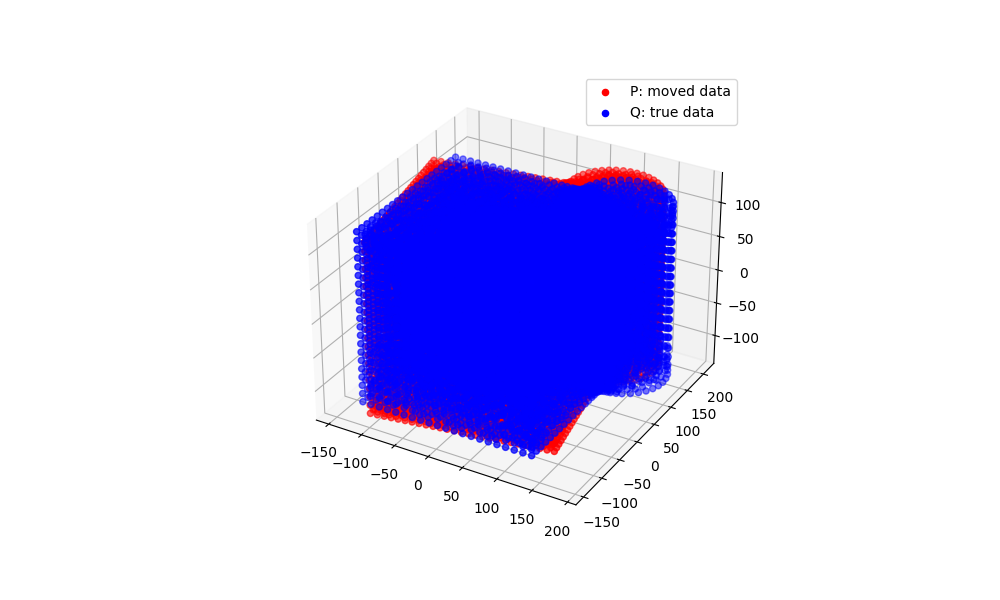

In [21]:
plot_data(X_mov,X_fix,"P: moved data", "Q: true data")

In [6]:
def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    x_q, y_q = Q
    # draw initial correspondeces
    corresp_lines = []
    for i, j in correspondences:
        corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='#336699')

    def animate(i):
        P_inc = P_values[i]
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        draw_inc_corresp(P_inc, Q, corresp_values[i])
        return (P_line,)
    
    def draw_inc_corresp(points_from, points_to, correspondences):
        for corr_idx, (i, j) in enumerate(correspondences):
            x = [points_from[0, i], points_to[0, j]]
            y = [points_from[1, i], points_to[1, j]]
            corresp_lines[corr_idx].set_data(x, y)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())

In [108]:
def get_correspondence_indices(P, Q,kd_tree=False):
    """For each point in P find closest one in Q."""
    p_size = P.shape[0]
    q_size = Q.shape[0]
    correspondences = []
    for i in range(p_size):
        p_point = P[i, :]
        min_dist = 10
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[j, :]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

# def draw_correspondeces(P, Q, correspondences, ax):
#     label_added = False
#     for i, j in correspondences:
#         x = [P[0, i], Q[0, j]]
#         y = [P[1, i], Q[1, j]]
#         if not label_added:
#             ax.plot(x, y, color='grey', label='correpondences')
#             label_added = True
#         else:
#             ax.plot(x, y, color='grey')
#     ax.legend()

In [11]:
from sklearn.neighbors import NearestNeighbors

In [13]:
neighbors = NearestNeighbors(n_neighbors=1)

neighbors.fit(X_fix)

distances,indices = neighbors.kneighbors(X_mov,return_distance=True)

In [22]:
indices

array([[1690],
       [2052],
       [  67],
       ...,
       [1231],
       [6467],
       [1597]], dtype=int64)

In [7]:
import sys

In [ ]:
correspondences = get_correspondence_indices(X_mov,X_fix)

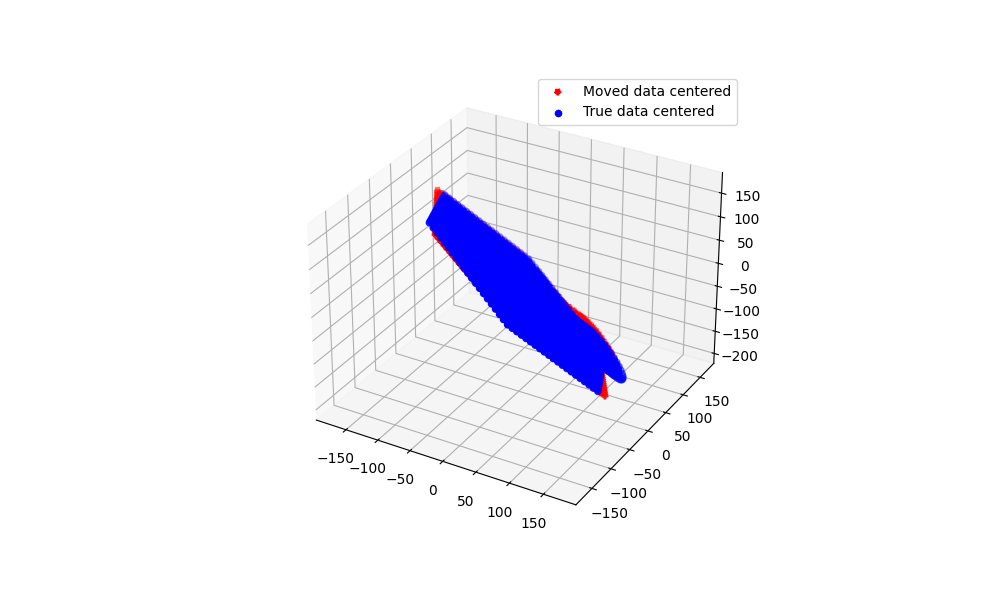

In [70]:
def center_data(data, exclude_indices=[]):
    reduced_data = np.delete(data, exclude_indices, axis=1)
    center = np.array([reduced_data.mean(axis=1)]).T
    return center, data - center

center_of_P, P_centered = center_data(X_mov)
center_of_Q, Q_centered = center_data(X_fix)
ax = plot_data(P_centered, Q_centered,
               label_1='Moved data centered',
               label_2='True data centered')
plt.show()

In [103]:
253/500

0.506

In [102]:
len([a for a,b in correspondences if b!=-1])

253

In [83]:
P_centered[[(0)]]

array([[171.9816632 , -74.21541758, -97.76624562]])

In [89]:
kernel=lambda diff: 1.0

In [98]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((2, 2))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[[i],:]
        q_point = Q[[j],:]
        weight = kernel(p_point - q_point)
        if weight < 1: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
        
    return cov, exclude_indices
cov, _ = compute_cross_covariance(P_centered[:500,:], Q_centered[:500,:], correspondences)

In [ ]:
def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = center_data(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for i in range(iterations):
        center_of_P, P_centered = center_data(P_copy, exclude_indices=exclude_indices)
        correspondences = get_correspondence_indices(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)  
        t = center_of_Q - R.dot(center_of_P)  
        P_copy = R.dot(P_copy) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, norm_values, corresp_values

P_values, norm_values, corresp_values = icp_svd(P, Q)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)